In [17]:
%load_ext autoreload
%autoreload 2
import os
from collections import defaultdict
if os.path.basename(os.path.realpath(os.getcwd())) == 'notebooks':
    print("changing dir...")
    os.chdir('../')
print(os.getcwd())
from stresstest.util import load_json

datasets = ['squad1', 'hotpotqa', 'newsqa', 'drop']
models = ['bidaf', 'bert-base', 'bert-large', 'roberta-base', 'roberta-large',
          'albert-base', 'albert-large', 'albert-xlarge', 'albert-xxlarge', 't5-small', 't5-base',
          't5-large']
result = defaultdict(dict)
for ds in datasets:
    ds_results = load_json(f'metrics/football/{ds}/eoi.json')
    for model in models:
        model_key = next((k for k in sorted(ds_results.keys(),key=len) if k.startswith(model)), None)
        if model_key:
            result[model][ds] = ds_results[model_key]
        else:
            result[model][ds] = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/viktor/workspace/mrc-stresstest


In [18]:
from stresstest.eval_utils import get_mean_var_ci, get_mean_var_ci_bernoulli
def format_overall(model_ds_result):
    original_dev_str = f"$?/?$"
    if model_ds_result:
        original_dev_em = model_ds_result.get('original_dev_em', None)
        original_dev_f1 = model_ds_result.get('original_dev_f1', None)
        if original_dev_em < 1 and original_dev_f1 < 1:
            original_dev_em *= 100
            original_dev_f1 *= 100
        if original_dev_em and original_dev_f1:
            original_dev_str = f"${round(original_dev_em,1)}/{round(original_dev_f1,1)}$"
        res = model_ds_result['evaluation_on_intervention']
        mean = res['mean']
        ci = res['95ci']
        latex_str = f"${round(mean*100)} \pm {round(ci*100)}$"
    else:
        latex_str = f"$?\pm ?$"
    return " & ".join([original_dev_str, latex_str])

def get_average(values, macro):
    if macro:
        vals = [v['evaluation_on_intervention']['mean'] for v in values]
        mean, var, ci = get_mean_var_ci(vals)
    else:
        tp = sum(v['behaviour']['right+control->change->right'] for v in values)
        tp_and_fn = sum(v['behaviour']['correct_baseline_control']for v in values)
        sample = [1] * tp + [0] * (tp_and_fn - tp)
        mean, var, ci = get_mean_var_ci_bernoulli(sample)
    return mean, var, ci

def format_average(values, macro=True):
    values = values.values()

    if all(v for v in values):
        mean, var, ci = get_average(values, macro)
        latex_str = f"${int(round(mean*100))} \pm {int(round(ci*100))}$"
    else:
        latex_str = "$?\pm ?$"
    return latex_str

def format_overall_average(result, macro=True):
    ds_tp = defaultdict(int)
    ds_n = defaultdict(int)
    overall = defaultdict(list)
    overall_dev_em = defaultdict(list)
    overall_dev_f1 = defaultdict(list)
    num_models = len(result)
    for _, model_result in result.items():
        for ds_name, res in model_result.items():

            if res:
                ds_tp[ds_name] += res['behaviour']['right+control->change->right']
                ds_n[ds_name] += res['behaviour']['correct_baseline_control']
                overall[ds_name].append( res["evaluation_on_intervention"]['mean'])
                overall_dev_em[ds_name].append(res["original_dev_em"])
                overall_dev_f1[ds_name].append(res['original_dev_f1'])

    micro_average = dict()
    macro_average = dict()
    original_average = dict()

    for (ds_name, tp), (_, n) in zip(ds_tp.items(), ds_n.items()):
        sample = [1] * tp + [0] * (n - tp)
        mean, var, ci = get_mean_var_ci_bernoulli(sample)
        latex_str = f"${int(round(mean*100))} \pm {int(round(ci*100))}$"
        micro_average[ds_name] = latex_str
        vals = overall[ds_name]
        mean, var, ci = get_mean_var_ci(vals)
        macro_average[ds_name] =  f"${int(round(mean*100))} \pm {int(round(ci*100))}$"
        em_vals = overall_dev_em[ds_name]
        em_avg = get_mean_var_ci(em_vals)[0]
        f1_vals = overall_dev_f1[ds_name]
        f1_avg = get_mean_var_ci(f1_vals)[0]
        original_average[ds_name] = f"${round(em_avg,1)}/{round(f1_avg,1)}$"
    total_tp = sum(ds_tp.values())
    total_n = sum(ds_n.values())
    sample = [1] * total_tp + [0] * (total_n - total_tp)
    mean, var, ci = get_mean_var_ci_bernoulli(sample)
    final_result =  [f"${int(round(mean*100))} \pm {int(round(ci*100))}$"]

    for ds_name in micro_average.keys():
        cell = []
        cell.append(original_average[ds_name])
        if macro:
            cell.append(macro_average[ds_name])
        else:
            cell.append(micro_average[ds_name])
        final_result.append(" & ".join(cell))
    #print(final_result)
    return final_result



from tabulate import tabulate
table = []
headers = [] #['average'] + datasets
for model_name, values in result.items():
        table.append([f"\\texttt{{{model_name}}}"] + [format_average(values,macro=False)] + [format_overall(values[d]) for d in datasets])
#print(format_overall_average(result, macro=False))
table.append(["\\texttt{average}"] + format_overall_average(result, macro=False))
print(tabulate(table, headers, tablefmt="latex_raw"))

\begin{tabular}{llllll}
\hline
 \texttt{bidaf}          & $11 \pm 3$ & $67.2/76.9$ & $12 \pm 4$ & $44.6/57.9$ & $4 \pm 3$  & $40.0/54.3$ & $13 \pm 5$ & $50.8/56.8$ & $18 \pm 12$ \\
 \texttt{bert-base}      & $13 \pm 2$ & $76.3/84.9$ & $13 \pm 3$ & $50.7/64.9$ & $17 \pm 4$ & $46.6/62.5$ & $13 \pm 3$ & $50.5/58.2$ & $10 \pm 3$  \\
 \texttt{bert-large}     & $15 \pm 2$ & $81.9/89.4$ & $15 \pm 3$ & $54.4/68.7$ & $14 \pm 3$ & $49.1/65.7$ & $14 \pm 4$ & $62.2/68.7$ & $16 \pm 3$  \\
 \texttt{roberta-base}   & $15 \pm 2$ & $82.4/89.9$ & $8 \pm 3$  & $51.9/66.4$ & $17 \pm 4$ & $50.8/66.9$ & $14 \pm 3$ & $63.5/69.3$ & $20 \pm 3$  \\
 \texttt{roberta-large}  & $18 \pm 1$ & $86.4/93.3$ & $16 \pm 3$ & $58.6/72.9$ & $21 \pm 3$ & $54.4/71.1$ & $15 \pm 3$ & $77.3/82.8$ & $20 \pm 2$  \\
 \texttt{albert-base}    & $14 \pm 2$ & $82.8/90.3$ & $10 \pm 3$ & $55.4/69.7$ & $17 \pm 3$ & $49.7/65.7$ & $11 \pm 3$ & $60.7/67.0$ & $18 \pm 4$  \\
 \texttt{albert-large}   & $16 \pm 1$ & $85.4/92.1$ & $18 \pm 3$ & $5

Ignored vs Confused

In [3]:
def get_ignored_confused(model_predicate=lambda x: True, ds_predicate=lambda x: True):
    ignored = 0
    confused = 0
    for model_name, model in result.items():
        if model_predicate(model_name):
            for ds_name, dsr in model.items():
                if dsr and ds_predicate(ds_name):
                    ignored += dsr['behaviour']['right+control->keep->wrong']
                    confused += dsr['behaviour']['right+control->change->wrong']
    return ignored, confused
ignored, confused = get_ignored_confused()
mean_ignored, _, ci = get_mean_var_ci_bernoulli([1] * ignored + [0] * confused)
print("Ignored")
print(f"{round(mean_ignored*100)}+/- {round(ci*100,1)}")
mean_confused, _, ci = get_mean_var_ci_bernoulli([0] * ignored + [1] * confused)
print("Confused")
print(f"{round(mean_confused*100)}+/- {round(ci*100,1)}")

Ignored
84+/- 0.5
Confused
16+/- 0.5


In [4]:
ignored_nobidaf, confused_nobidaf = get_ignored_confused(lambda x: "bidaf" in x)
print(ignored_nobidaf)
print(confused_nobidaf)
print(ignored_nobidaf/(confused_nobidaf+ignored_nobidaf))

930
168
0.8469945355191257


In [5]:
ignored_squad_only, confused_squad_only = get_ignored_confused(ds_predicate=lambda x: "squad" in x)
print(ignored_squad_only)
print(confused_squad_only)
print(ignored_squad_only/(ignored_squad_only+confused_squad_only))

5887
1055
0.8480265053298761


In [6]:
def get_by_sam(model_predicate=lambda x: True, ds_predicate=lambda x: True):
    by_sam_tp = defaultdict(int)
    by_sam_n = defaultdict(int)
    for model_name, model in result.items():
        if model_predicate(model_name):
            for ds_name, dsr in model.items():
                if dsr and ds_predicate(ds_name):
                    for sam, sr in dsr['by_sam'].items():
                        by_sam_tp[sam] += sr['tp']
                        by_sam_n[sam] += sr['n']
    return by_sam_tp, by_sam_n

by_sam_tp, by_sam_n = get_by_sam()
for (sam_type, tp), (_, n) in zip(by_sam_tp.items(), by_sam_n.items()):
    mean_sam, _, ci = get_mean_var_ci_bernoulli([1] * tp + [0] * (n-tp))
    print(f"Sam: {sam_type}")
    print(f"{round(mean_sam*100)}+/- {round(ci*100,1)}")

Sam: MD
18+/- 1.1
Sam: RB
12+/- 0.9
Sam: VB-neg-impl
19+/- 1.1
Sam: VB-pol-rev
23+/- 1.1
Sam: VP-neg-impl
17+/- 1.0
Sam: VP-pol-rev
21+/- 1.2


In [7]:
no_bidaf_by_sam_tp, no_bidaf_by_sam_n = get_by_sam(lambda x: "bidaf" not in x)
print("No Bidaf")
for (sam_type, tp), (_, n) in zip(no_bidaf_by_sam_tp.items(), no_bidaf_by_sam_n.items()):
    mean_sam, _, ci = get_mean_var_ci_bernoulli([1] * tp + [0] * (n-tp))
    print(f"Sam: {sam_type}")
    print(f"{round(mean_sam*100)}+/- {round(ci*100,1)}")

No Bidaf
Sam: MD
19+/- 1.1
Sam: RB
12+/- 0.9
Sam: VB-neg-impl
20+/- 1.2
Sam: VB-pol-rev
24+/- 1.2
Sam: VP-neg-impl
17+/- 1.1
Sam: VP-pol-rev
21+/- 1.2


In [8]:
def get_by_num_mod(model_predicate=lambda x: True, ds_predicate=lambda x: True):
    by_num_mod_tp = defaultdict(int)
    by_num_mod_n = defaultdict(int)
    for model_name, model in result.items():
        if model_predicate(model_name):
            for ds_name, dsr in model.items():
                if dsr and ds_predicate(ds_name):
                    for sam, sr in dsr['by_num_modifier'].items():
                        by_num_mod_tp[sam] += sr['tp']
                        by_num_mod_n[sam] += sr['n']
    return by_num_mod_tp, by_num_mod_n

by_num_mod_tp, by_num_mod_n = get_by_num_mod()
for (sam_type, tp), (_, n) in zip(by_num_mod_tp.items(), by_num_mod_n.items()):
    mean_sam, _, ci = get_mean_var_ci_bernoulli([1] * tp + [0] * (n-tp))
    print(f"Sam: {sam_type}")
    print(f"{round(mean_sam*100)}+/- {round(ci*100,1)}")

Sam: 1
22+/- 0.8
Sam: 2
18+/- 0.8
Sam: 3
15+/- 0.7


In [9]:
no_bidaf_by_sam_tp, no_bidaf_by_sam_n = get_by_sam(lambda x: "bidaf" not in x)
print("No Bidaf")
for (sam_type, tp), (_, n) in zip(no_bidaf_by_sam_tp.items(), no_bidaf_by_sam_n.items()):
    mean_sam, _, ci = get_mean_var_ci_bernoulli([1] * tp + [0] * (n-tp))
    print(f"Sam: {sam_type}")
    print(f"{round(mean_sam*100)}+/- {round(ci*100,1)}")

No Bidaf
Sam: MD
19+/- 1.1
Sam: RB
12+/- 0.9
Sam: VB-neg-impl
20+/- 1.2
Sam: VB-pol-rev
24+/- 1.2
Sam: VP-neg-impl
17+/- 1.1
Sam: VP-pol-rev
21+/- 1.2


In [10]:
model_sizes = load_json('metrics/transformers.json')
score_by_size = dict()
scores = []
errors = []
num_params = []
for model, values in result.items():
    values = values.values()
    if all(v for v in values):
        score, _, error = get_average(values, macro=False)
        score_by_size[model] = (model_sizes[model], score)
        scores.append(score)
        errors.append(error)
        num_params.append(model_sizes[model])
print(score_by_size)

{'bidaf': (2582095, 0.1094017094017094), 'bert-base': (109483778, 0.13437703848662752), 'bert-large': (335143938, 0.14736297828335057), 'roberta-base': (124647170, 0.15057283142389524), 'roberta-large': (355361794, 0.18279944289693592), 'albert-base': (90741506, 0.14099526066350712), 'albert-large': (310437378, 0.16382128586996003), 'albert-xlarge': (1223045634, 0.2688895686754359), 'albert-xxlarge': (2443594242, 0.26564123882768653), 't5-small': (60506880, 0.1019036954087346), 't5-base': (222903936, 0.1597918989223337), 't5-large': (737668608, 0.1954322058398381)}


(0.9401806004484999, 1.6810648857189065e-05)
SpearmanrResult(correlation=0.9370629370629372, pvalue=6.99316495321054e-06)
1.681064885718907e-05 0.9401806004484999
[0.02529432768771428, 0.017072767668528624, 0.01579778300763643, 0.016372056732466167, 0.014135384754913799, 0.016602057253713096, 0.013825463644232622, 0.015199142899022022, 0.01248050910052062, 0.01403019751999074, 0.0138440147499648, 0.013214544541555184]
12
12
-0.6642374546508132
0.029795299653508956
0.0035987967585575198
['bidaf', 'bidaf-elmo', 'bert-base', 'bert-large', 'roberta-base', 'roberta-large', 'albert-base', 'albert-large', 'albert-xlarge', 'albert-xxlarge', 't5-small', 't5-base', 't5-large']
(26.706, 0.134) +- (0.017,0.017)
(28.320, 0.147) +- (0.016,0.016)
(26.893, 0.151) +- (0.016,0.016)
(28.405, 0.183) +- (0.014,0.014)
(26.435, 0.141) +- (0.017,0.017)
(28.210, 0.164) +- (0.014,0.014)
(30.188, 0.269) +- (0.015,0.015)
(31.186, 0.266) +- (0.012,0.012)
(25.851, 0.102) +- (0.014,0.014)
(27.732, 0.160) +- (0.014,0

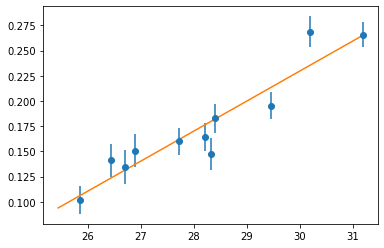

In [11]:
from scipy.stats import pearsonr, spearmanr, linregress
import numpy as np
import matplotlib.pyplot as plt
print(pearsonr(np.log2(num_params[1:]), scores[1:]))
print(spearmanr(num_params, scores))
slope, intercept, r_value, p_value, std_err = linregress(np.log2(num_params[1:]),scores[1:])
print(p_value, r_value)
x = np.linspace(25, max(np.log2(num_params[1:])), 15)
print(errors)
print(len(num_params))
print(len(scores))

plt.errorbar(np.log2(num_params[1:]), scores[1:], fmt='o', yerr=errors[1:])
plt.plot(x[1:],  intercept + slope*x[1:], linestyle='-')
plt.show()
print(intercept)
print(slope)
print(std_err)
print([model for model in result.keys()])
for (x,y), error in zip(zip(np.log2(num_params[1:]), scores[1:]),errors[1:]):
    print(f"({x:.03f}, {y:.03f}) +- ({error:.03f},{error:.03f})")

SpearmanrResult(correlation=0.9370629370629372, pvalue=6.99316495321054e-06)
0.001017709822629197 0.8226413465456951
[0.02529432768771428, 0.017072767668528624, 0.01579778300763643, 0.016372056732466167, 0.014135384754913799, 0.016602057253713096, 0.013825463644232622, 0.015199142899022022, 0.01248050910052062, 0.01403019751999074, 0.0138440147499648, 0.013214544541555184]
12
12
-0.31003710774884274
0.0173622746555865
0.0037946601702024676
(21.300110650336272, 0.1094017094017094)
(26.706141883421367, 0.13437703848662752)
(28.320205598071325, 0.14736297828335057)
(26.893274887228642, 0.15057283142389524)
(28.404713340382028, 0.18279944289693592)
(26.435259267923797, 0.14099526066350712)
(28.209727033791154, 0.16382128586996003)
(30.18783108836444, 0.2688895686754359)
(31.186357600004932, 0.26564123882768653)
(25.85059585912028, 0.1019036954087346)
(27.731846850786496, 0.1597918989223337)
(29.458397601170798, 0.1954322058398381)


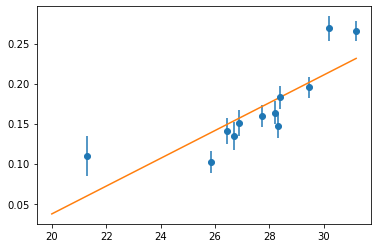

In [12]:
print(spearmanr(num_params, scores))
slope, intercept, r_value, p_value, std_err = linregress(np.log2(num_params),scores)
print(p_value, r_value)
x = np.linspace(20, max(np.log2(num_params)), 20)
print(errors)
print(len(num_params))
print(len(scores))

plt.errorbar(np.log2(num_params), scores, fmt='o', yerr=errors)
plt.plot(x,  intercept + slope*x, linestyle='-')
plt.show()

print(intercept)
print(slope)
print(std_err)

for d, err in zip(zip(np.log2(num_params), scores), errors):
    print(d, )

In [15]:
datasets = ['squad1']
models = ['bidaf', 'bert-base', 'bert-large', 'roberta-base', 'roberta-large',
          'albert-base', 'albert-large', 'albert-xlarge', 'albert-xxlarge', 't5-small', 't5-base',
          't5-large']
result = defaultdict(dict)
for ds in datasets:
    ds_results = load_json(f'playground/football/{ds}/eoi.json')
    for model in models:
        model_key = next((k for k in sorted(ds_results.keys(),key=len) if k.startswith(model)), None)
        if model_key:
            result[model][ds] = ds_results[model_key]
        else:
            result[model][ds] = None
from tabulate import tabulate
table = []
headers = [] #['average'] + datasets
for model_name, values in result.items():
        table.append([f"\\texttt{{{model_name}}}"] + [format_average(values,macro=False)] + [format_overall(values[d]) for d in datasets])
#print(format_overall_average(result, macro=False))
table.append(["\\texttt{average}"] + format_overall_average(result, macro=False))
print(tabulate(table, headers))

-----------------------  ----------  ------------------------
\texttt{bidaf}           $12 \pm 4$  $67.2/76.9$ & $12 \pm 4$
\texttt{bert-base}       $13 \pm 3$  $76.3/84.9$ & $13 \pm 3$
\texttt{bert-large}      $15 \pm 3$  $81.9/89.4$ & $15 \pm 3$
\texttt{roberta-base}    $8 \pm 3$   $82.4/89.9$ & $8 \pm 3$
\texttt{roberta-large}   $16 \pm 3$  $86.4/93.3$ & $16 \pm 3$
\texttt{albert-base}     $10 \pm 3$  $82.8/90.3$ & $10 \pm 3$
\texttt{albert-large}    $18 \pm 3$  $85.4/92.1$ & $18 \pm 3$
\texttt{albert-xlarge}   $19 \pm 2$  $87.1/93.5$ & $19 \pm 2$
\texttt{albert-xxlarge}  $29 \pm 2$  $88.2/94.4$ & $29 \pm 2$
\texttt{t5-small}        $13 \pm 3$  $76.8/85.8$ & $13 \pm 3$
\texttt{t5-base}         $16 \pm 3$  $82.4/90.6$ & $16 \pm 3$
\texttt{t5-large}        $21 \pm 2$  $86.3/93.1$ & $21 \pm 2$
\texttt{average}         $18 \pm 1$  $76.4/83.2$ & $18 \pm 1$
-----------------------  ----------  ------------------------


In [16]:
datasets = ['squad1']
models = ['bidaf', 'bert-base', 'bert-large', 'roberta-base', 'roberta-large',
          'albert-base', 'albert-large', 'albert-xlarge', 'albert-xxlarge', 't5-small', 't5-base',
          't5-large']
result = defaultdict(dict)
for ds in datasets:
    ds_results = load_json(f'playground/football/{ds}/eoi-rem5.json')
    for model in models:
        model_key = next((k for k in sorted(ds_results.keys(),key=len) if k.startswith(model)), None)
        if model_key:
            result[model][ds] = ds_results[model_key]
        else:
            result[model][ds] = None
from tabulate import tabulate
table = []
headers = [] #['average'] + datasets
for model_name, values in result.items():
        table.append([f"\\texttt{{{model_name}}}"] + [format_average(values,macro=False)] + [format_overall(values[d]) for d in datasets])
#print(format_overall_average(result, macro=False))
table.append(["\\texttt{average}"] + format_overall_average(result, macro=False))
print(tabulate(table, headers))



-----------------------  ----------  ------------------------
\texttt{bidaf}           $12 \pm 4$  $67.2/76.9$ & $12 \pm 4$
\texttt{bert-base}       $13 \pm 3$  $76.3/84.9$ & $13 \pm 3$
\texttt{bert-large}      $15 \pm 3$  $81.9/89.4$ & $15 \pm 3$
\texttt{roberta-base}    $8 \pm 2$   $82.4/89.9$ & $8 \pm 2$
\texttt{roberta-large}   $16 \pm 3$  $86.4/93.3$ & $16 \pm 3$
\texttt{albert-base}     $10 \pm 3$  $82.8/90.3$ & $10 \pm 3$
\texttt{albert-large}    $18 \pm 3$  $85.4/92.1$ & $18 \pm 3$
\texttt{albert-xlarge}   $19 \pm 2$  $87.1/93.5$ & $19 \pm 2$
\texttt{albert-xxlarge}  $29 \pm 2$  $88.2/94.4$ & $29 \pm 2$
\texttt{t5-small}        $13 \pm 3$  $76.8/85.8$ & $13 \pm 3$
\texttt{t5-base}         $16 \pm 3$  $82.4/90.6$ & $16 \pm 3$
\texttt{t5-large}        $21 \pm 2$  $86.3/93.1$ & $21 \pm 2$
\texttt{average}         $18 \pm 1$  $76.4/83.2$ & $18 \pm 1$
-----------------------  ----------  ------------------------
